In [345]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import schema

In [346]:
signal_params = [
    {
        'freq_hz': 0.15,
        'ampl': 0.837,
        'phase_rad': 0.0
    },
    {
        'freq_hz': 0.2,
        'ampl': 0.286,
        'phase_rad': 0.0
    },
    {
        'freq_hz': 0.12,
        'ampl': 0.227,
        'phase_rad': 0.0
    },
    {
        'freq_hz': 0.06,
        'ampl': 0.183,
        'phase_rad': 0.0
    }
]

sampling_freq_hz: float = 1000/200 #200 ms period
sampling_duration_s = 1510/1000

display_freq_limit = (0.025, 1)

In [347]:
#This gives us a new sampling method which mimics the actual scheduling algorithm 
#These are the intervals at which we will sample the given signals (signal_params)

json_file_actual = open("../tests/actual.log")


scheduleA = np.array([])
scheduleB = np.array([])
scheduleC = np.array([])

for line in json_file_actual:
    if(line.find("ScheduleTooTight") != -1): #get the line we want to measure
        startInd = int(line.find("["))+1
        endInd = int(len(line)-2)
    
        values = line[startInd:endInd] #get the lists without the end brackets
        tasks = values.split(',')
        for task in tasks:
            actual = task[task.find("\"")+1:len(task)-2] #get rid of the quotation marks
            times = actual.split('|')
            label = times[0]
            start = float(float(times[1])/1000)
            if label == 'A':
                scheduleA = np.append(scheduleA, start)
            elif label == 'B':
                scheduleB = np.append(scheduleB, start)
            elif label == 'C':
                scheduleC = np.append(scheduleC, start)
            else:
                print("Error, No Acceptable Label.\n")
        break

print(scheduleA)
print(scheduleB)

[0.  0.5 1. ]
[0.2 0.4 0.7 0.8 1.2 1.4]


In [348]:
#temp 
# delay_injection = 10
# delay_amplitude = 0.1

sampling_int = 1.0 / sampling_freq_hz

#selects evenly spaced intervals when the samples are actually taken

#REFERENCE SAMPLING THAT I NEED TO FIX

#Reference sampling number must match the number of given samples in the schedule being compared
#Need to figure out how to compare multiple 
sampling_int = (sampling_duration_s + sampling_int)/len(scheduleB)

reference_sampling = np.arange(200/1000, sampling_duration_s + sampling_int, sampling_int, dtype=np.float64)


#total number of samples taken
n_samples = len(reference_sampling)


# interval_priority_sampling = reference_sampling + np.heaviside(np.arange(-1 * delay_injection, sampling_duration_s - delay_injection + sampling_int, sampling_int), 1) * delay_amplitude

# increment_priority_sampling = reference_sampling.copy()
# increment_priority_sampling[delay_injection] += delay_amplitude


# random_offset = reference_sampling + np.random.normal(0, 5e-3, n_samples)

sampling_behaviors = {
    'Original': reference_sampling,
    # 'Interval': interval_priority_sampling,
    # 'Increment': increment_priority_sampling,
    # 'ScheduleA': scheduleA,
    'ScheduleB': scheduleB
    # 'ScheduleC': scheduleC
    # 'Random': random_offset
}

print(type(reference_sampling))
# print(type(interval_priority_sampling))
print(type(scheduleA))
print(type(scheduleB))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [349]:
class SigGen:
    #Validates the data -> are the numbers entered actualy floats, etc.
    def __init__(self, params: List[Dict[str, float]]):
        print("Signal Initiated...\n")
        signal_params_schema = schema.Schema(
            [
                {
                    'freq_hz': schema.Or(int, float),
                    'ampl': schema.Or(int, float),
                    'phase_rad': schema.Or(int, float)
                }
            ]
        )
        signal_params_schema.validate(params)
        self._params = params
    
    def add_signal(self, freq_hz: float, ampl: float, phase_rad: float):
        print("Signal added...\n")
        self._params.append({
            'freq_hz': freq_hz,
            'ampl': ampl,
            'phase_rad': phase_rad
        })
    

    #Generate the height of each signal at a given time?
    def generate(self, t: np.ndarray) -> np.ndarray:
        output = np.zeros(t.shape, t.dtype)
        for component in signal_params:
            # print("Component is: ")
            # print(component)
            # print("Component length is: ")
            # print(len(output))
            output += component['ampl'] * np.sin(t * 2 * np.pi * component['freq_hz'] + component['phase_rad'])
            # print("Output is:")
            # print(output)
            # print("Output length is: ")
            # print(len(output))
        return output
    
    def __call__(self, t: np.ndarray) -> np.ndarray:
        return self.generate(t)

sig_gen = SigGen(signal_params)

Signal Initiated...



In [350]:
reference_signal = sig_gen(reference_sampling)
reference_spectrum = np.fft.rfft(reference_signal)

signals = {label:sig_gen(sampling_sequence)
          for label, sampling_sequence in sampling_behaviors.items()}
spectra = {label:np.fft.rfft(signal) for label, signal in signals.items()}
fft_freq = {label:np.fft.rfftfreq(len(timing), sampling_int)
            for label, timing in sampling_behaviors.items()}

print(len(scheduleA))
print(scheduleA)
print(len(scheduleB))
print(scheduleB)
print(len(reference_sampling))
print(reference_sampling)

3
[0.  0.5 1. ]
6
[0.2 0.4 0.7 0.8 1.2 1.4]
6
[0.2   0.485 0.77  1.055 1.34  1.625]



Label: 
Original

Sequence Length: 
6

Label: 
ScheduleB

Sequence Length: 
6


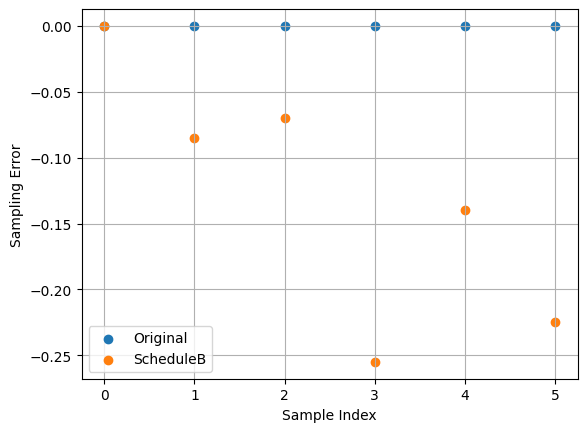

In [351]:
fig = plt.figure()
ax = fig.add_subplot(111)


for label, sequence in sampling_behaviors.items():
    print("\nLabel: ")
    print(label)
    print("\nSequence Length: ")
    print(len(sequence))
    ax.scatter(np.arange(len(sequence)), sequence - reference_sampling, label=label)

ax.legend()
ax.set_ylabel('Sampling Error')
ax.set_xlabel('Sample Index')
ax.grid()

Text(0.5, 0, 'Time (s)')

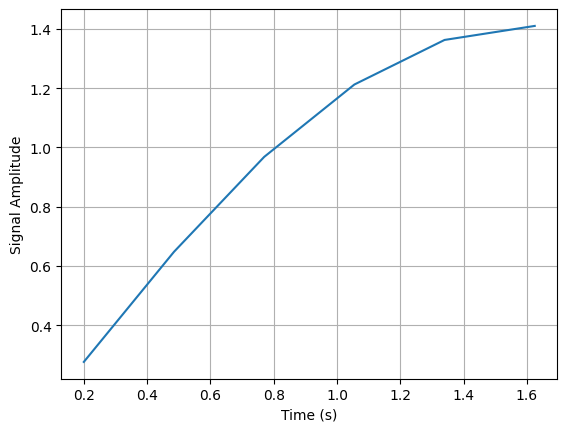

In [352]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(reference_sampling, reference_signal)
ax.grid()

ax.set_ylabel('Signal Amplitude')
ax.set_xlabel('Time (s)')

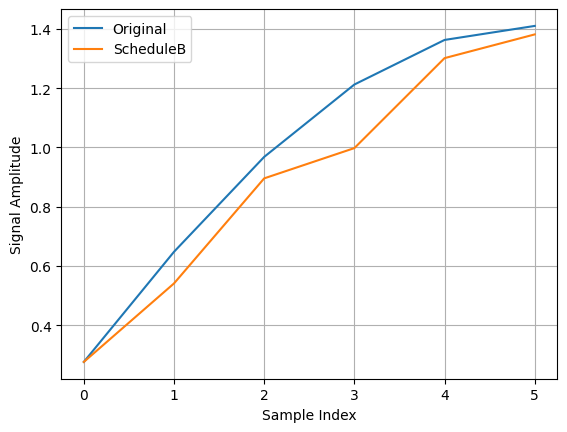

In [353]:
fig = plt.figure()
ax = fig.add_subplot(111)

for label, signal in signals.items():
    ax.plot(np.arange(len(signal)), signal, label=label)

ax.grid()
ax.set_ylabel('Signal Amplitude')
ax.set_xlabel('Sample Index')
ax.legend()

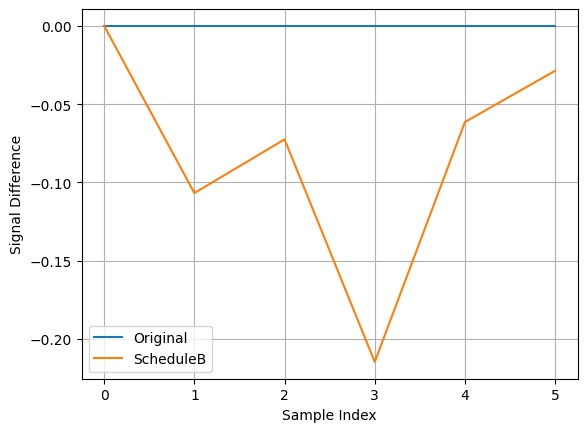

In [354]:
fig = plt.figure()
ax = fig.add_subplot(111)

for label, signal in signals.items():
    ax.plot(np.arange(len(signal)), signal - reference_signal, label=label)

ax.grid()
ax.set_ylabel('Signal Difference')
ax.set_xlabel('Sample Index')
ax.legend()

(0.025, 1.0)

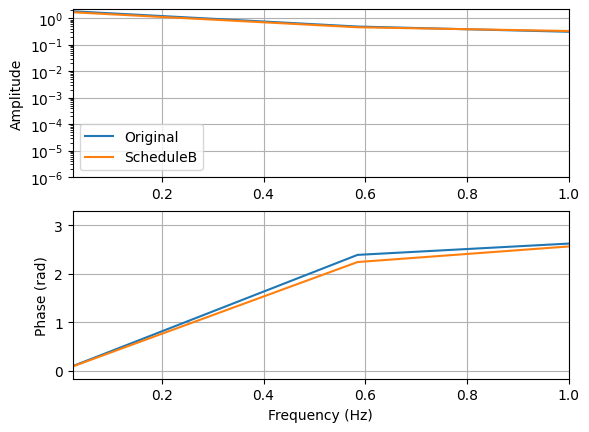

In [355]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

for label in spectra:
    ax1.plot(fft_freq[label], 2 / n_samples * np.abs(spectra[label]), label=label)
    ax2.plot(fft_freq[label], np.angle(spectra[label]))

ax1.grid()
ax2.grid()
ax1.set_ylabel('Amplitude')
ax2.set_ylabel('Phase (rad)')
ax2.set_xlabel('Frequency (Hz)')
ax1.legend()
ax1.semilogy()
ax1.set_ylim(1e-6)
ax1.set_xlim(display_freq_limit[0], display_freq_limit[1])

(0.21903780495666292, 1)

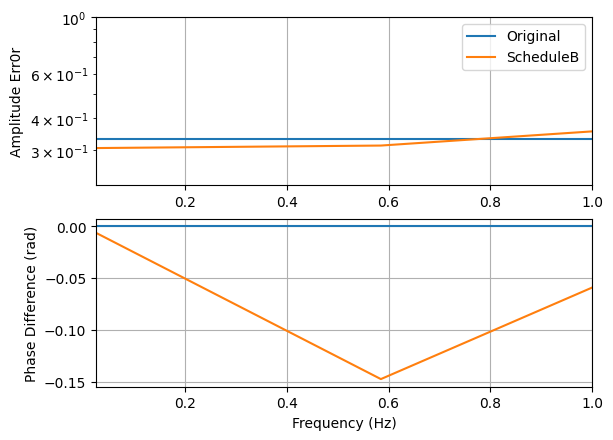

In [356]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

for label in spectra:
    ax1.plot(fft_freq[label], 2 / n_samples * (np.abs(spectra[label]) / np.abs(reference_spectrum)), label=label)
    ax2.plot(fft_freq[label], np.angle(spectra[label]) - np.angle(reference_spectrum))

ax1.grid()
ax2.grid()
ax1.legend()
ax1.set_ylabel('Amplitude Err0r')
ax2.set_ylabel('Phase Difference (rad)')
ax2.set_xlabel('Frequency (Hz)')
ax1.semilogy()
ax1.set_xlim(display_freq_limit[0], display_freq_limit[1])
ax1.set_ylim(top=1)
